In [1]:
import numpy as np
import sys
sys.path.insert(0, '..') 
import matplotlib.pyplot as plt
from EMQST_lib import support_functions as sf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from EMQST_lib import clustering as cl
import pickle 
import glob
from EMQST_lib import support_functions as sf
plt.rcParams.update({'font.size': 15})
np.set_printoptions(precision=3)
%load_ext autoreload
%autoreload 2

In this notebook are the plotting functions used to display the results presented in "Mitigation of correlated readout errors without randomized measurements".
The available results used in the paper is under Correlated_QREM_results.

# QREM on 16 qubits with structure, using (realistic exp. data)

[[2], [11], [0, 1], [8, 9, 10], [14], [6, 7], [3], [15], [4, 5], [12, 13]]
dict_keys(['no_QREM', 'factorized_QREM', 'two_RDM_QREM', 'classical_correlated_QREM', 'correlated_QREM', 'Z', 'noise_cluster_labels', 'two_point_corr_labels', 'rho_true_array', 'traced_down_rho_true_array', 'initial_cluster_size', 'noise_mode', 'n_QDT_shots', 'n_QST_shots_total', 'n_cores', 'n_qubits', 'n_averages', 'state_size_array', 'result_name_list', 'comparison_modes', 'dendrogram_cutoff', 'cluster_QDOT'])


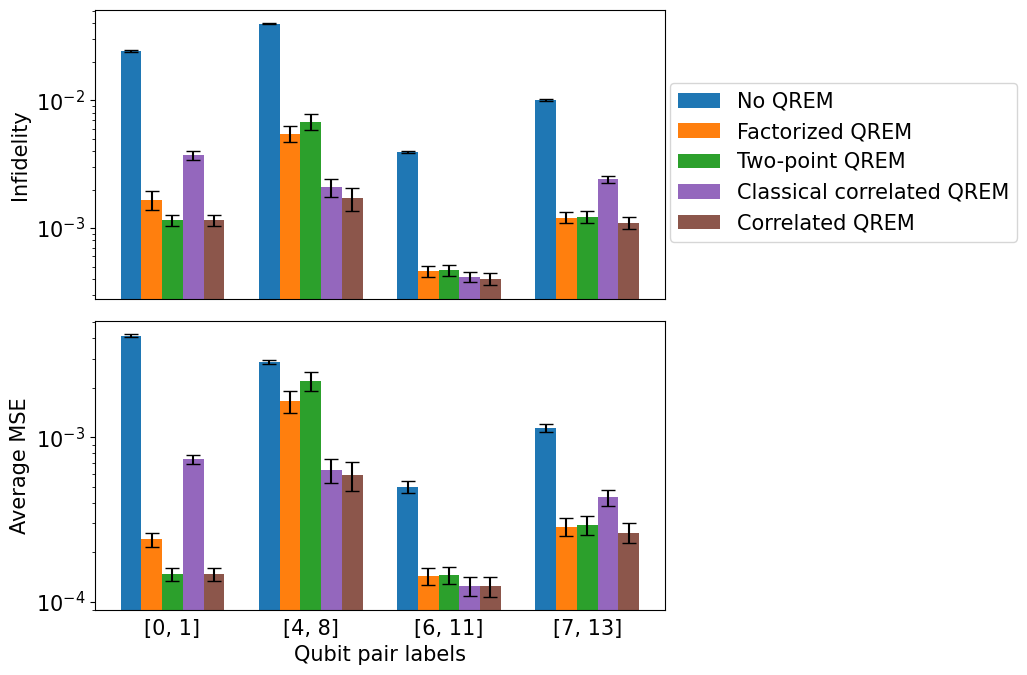

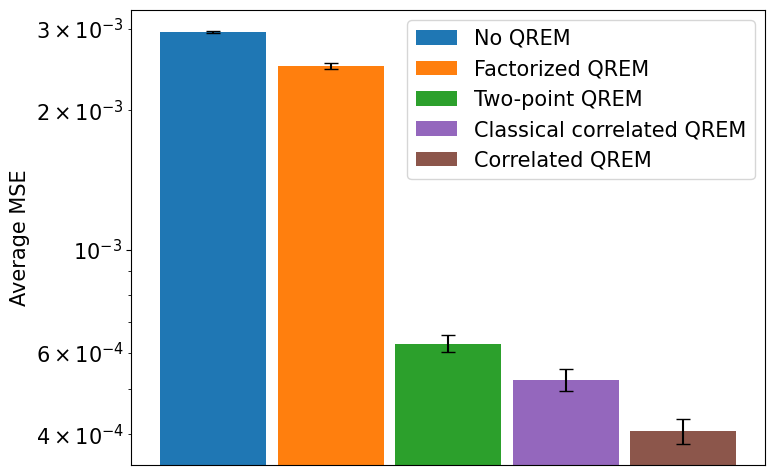

In [10]:
# Load the data from the 16 qubit example
perm_data_path = "Correlated_QREM_results/16_exp_example/100k_QST_shots_paper_sim"

# For loading of 
file_list = glob.glob(f'{perm_data_path}/**/*.pkl', recursive=True)
dict_array = []
for file in file_list:
    with open(file, 'rb') as f:
        dict_array.append(pickle.load(f))


cutoff = dict_array[0]['dendrogram_cutoff']

noise_labels = dict_array[0]['noise_cluster_labels']
print(noise_labels)
print(dict_array[0].keys())
n_averages = dict_array[0]['n_averages']
two_point_corr_labels   = dict_array[0]['two_point_corr_labels']
traced_down_rho_true_array = dict_array[0]['traced_down_rho_true_array']


# Generate average Pauli expectation values
op_string_array = sf.generate_two_qubit_Pauli_string(use_identity = False)

true_exp_value = ot.compute_state_array_exp_values([traced_down_rho_true_array],op_string_array)[0]

inf_array = []
state_array = []
MSE_array = []
for dict in dict_array:
    state, label_array = ot.load_state_array_from_result_dict(dict)
    # The states has shapes [n_modes, n_averages, len(two_point_corr_labels), 2**n_qubits, 2**n_qubits]
    inf_array.append(ot.compute_mode_mean_infidelitites(state, traced_down_rho_true_array))#[filter_array]
    state_array.append(state)
    exp_value = ot.compute_state_array_exp_values(state,op_string_array)
    MSE_array.append(ot.compute_op_and_n_averages_mean_MSE(exp_value, true_exp_value))
    # Resulting arrays have shapes [std_averages,n_modes,n_correlators]

# Average over the std_deviation runs
mean_inf_array = np.mean(inf_array, axis=0)
mean_MSE_array = np.mean(MSE_array, axis=0)



fig, ax = plt.subplots(2,1)
if len(two_point_corr_labels) > 4:
    x = np.arange(4)  # How many correlators to plot
else:
    x = np.arange(len(two_point_corr_labels))
width = 0.15  # the width of the bars
multiplier = 0
corr_label_index = [0,1,2,3]

color=['C0', 'C1','C2','C4','C5']
for i in range(len(label_array)):
    offset = width * multiplier
    rects = ax[0].bar(x + offset,mean_inf_array[i,corr_label_index], width, label=label_array[i], color = color[i])
    ax[0].errorbar(x + offset, mean_inf_array[i,corr_label_index], yerr=np.std(inf_array, axis=0)[i,corr_label_index], fmt='none', ecolor='k', capsize=5)
    multiplier += 1
ax[0].set_yscale('log')
if len(two_point_corr_labels) > 4:
    ax[0].set_xticks(x + 2.3*width, two_point_corr_labels[:4])
else:
    ax[0].set_xticks(x + 2.3*width, two_point_corr_labels)
ax[0].set_ylabel('Infidelity')



    
if len(two_point_corr_labels) > 4:
    corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels[corr_label_index]]
else:
    corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels]

multiplier = 0

for i in range(len(label_array)):
    offset = width * multiplier
    
    rects = ax[1].bar(x + offset, mean_MSE_array[i,corr_label_index], width, color = color[i])
    ax[1].errorbar(x + offset, mean_MSE_array[i,corr_label_index], yerr=np.std(MSE_array, axis=0)[i,corr_label_index], fmt='none', ecolor='k', capsize=5)
        #ax[1].plot(x + offset, perfect_clustering_MSE[i,:4], "kx")

    #ax[1].plot(x + offset, perfect_clustering_MSE[i], "kx")
    multiplier += 1
    
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')
ax[-1].set_xticks(x + 2*width, corr_x_label)
ax[-1].set_xlabel('Qubit pair labels')
img = plt.imread("images/Cluster_formation_16_qubit_example.png")
fig.figimage(img, 2120, 200, zorder=3, alpha=1)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(0.96,0.75))
fig.savefig(f'images/Results/Correlator_spesific_MSE_16_example.png', dpi = 300,bbox_inches='tight')
handels, labels = ax[0].get_legend_handles_labels()





fig_main, ax_main = plt.subplots(1,1)

mean_over_correlators = np.mean(mean_MSE_array, axis=1)
std_mean_over_correlators = np.mean(MSE_array,axis = 2)
#perfect_mean_MSE = np.mean(perfect_clustering_MSE, axis=1)
bars = ax_main.bar(label_array, mean_over_correlators, width*6, color=['C0', 'C1','C2','C4','C5'])
ax_main.errorbar(label_array, mean_over_correlators, yerr=np.std(std_mean_over_correlators, axis=0), fmt='none', ecolor='k', capsize=5)
#ax_main.plot(label_array, perfect_mean_MSE, "kx")
#ax_main.set_title('Average MSE over random correlators')
ax_main.set_ylabel('Average MSE')
ax_main.set_yscale('log')
ax_main.legend(handels, labels)
ax_main.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
fig_main.set_size_inches(8, 5)
fig_main.tight_layout()
fig_main.savefig(f'images/Results/main_result_16_example.png', dpi = 300,bbox_inches='tight')
#fig_main.legend(loc='center left', bbox_to_anchor=(1,0.75))



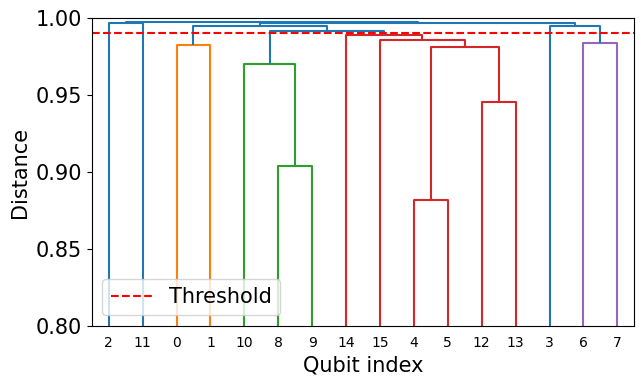

In [4]:
# Plotting dendrograms
# update_cutoffs = [ 0.91, 0.75, 0.65, 0.4]
# inital_cluster = dict_array[0]['initial_cluster_size']
# cluster  = cl.get_true_cluster_labels(inital_cluster)
# for entry in cluster:
#     print(entry)
# for dict in dict_array:
    
#     Z = dict['Z']
#     #print(rot_dict["noise_cluster_labels"])
#     #print(rot_dict['two_point_corr_labels'])
#     #print(rot_dict[''])
#     cutoff = dict['dendrogram_cutoff']
#     vis.plot_dendrogram(Z,save_path=f'{perm_data_path}', cutoff = cutoff,y_lim =(0.8,1) )
    #k_dict['noise_cluster_labels'] = cl.compute_noise_cluster_labels(k_dict['Z'], k_dict['dendrogram_cutoff'])
vis.plot_dendrogram(dict_array[0]['Z'],save_path=f'', cutoff = dict_array[0]['dendrogram_cutoff'],y_lim =(0.8,1) )

# ISWAP noise

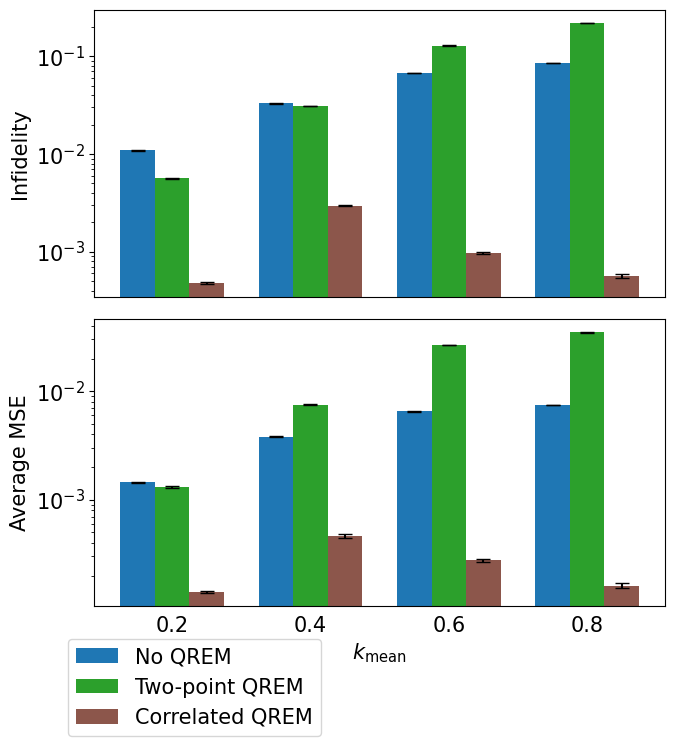

In [5]:
perm_data_path = "Correlated_QREM_results/iswap_example/100k_QST_shots_paper_sim"

# For loading of 
file_list = glob.glob(f'{perm_data_path}/**/*.pkl', recursive=True)
dict_array = []
for file in file_list:
    with open(file, 'rb') as f:
        dict_array.append(pickle.load(f))


# # Compute infidelities:
# The matrix has the shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels) , 2**n_qubits, 2**n_qubits]
# traced_down_rho_true_array has the shape [n_averages, n_two_point_corr, 2**n_qubits, 2**n_qubits]



k_mean_array = [0.2, 0.4, 0.6, 0.8]


traced_down_rho_true_array = dict_array[0][0]['traced_down_rho_true_array']
n_averages = dict_array[0][0]['n_averages']
two_point_corr_labels   = dict_array[0][0]['two_point_corr_labels']
n_QST_shots = dict_array[0][0]['n_QST_shots_total']

# Generate average Pauli expectation values
op_string_array = sf.generate_two_qubit_Pauli_string(use_identity = False)

true_exp_value = ot.compute_k_mean_expectation_values([[traced_down_rho_true_array]],op_string_array)[0]

# We need to treat each k-mean on it's own.
state_matrix = []
inf_matrix = []
inf = []
MSE = []
#perfect_clustering_state_matrix = []
for std_it in range(len(dict_array)):
    k_state_matrix = []
    for k_it in range(len(dict_array[std_it])):
        state_array, label_array = ot.load_state_array_from_result_dict(dict_array[std_it][k_it])
        #perfect_clustering_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict_array[k_it])
        k_state_matrix.append(state_array)
        
        #perfect_clustering_state_matrix.append(perfect_clustering_state_array)
    state_matrix.append(k_state_matrix)
    inf_k_mean= ot.k_mean_infidelity_computation(k_state_matrix, traced_down_rho_true_array).T # T is to swap order of modes and k_mean
    inf.append(inf_k_mean)
    exp_value = ot.compute_k_mean_expectation_values(k_state_matrix,op_string_array)
    MSE_k_mean = ot.compute_k_mean_mean_MSE(exp_value, true_exp_value).T # Transpose to make method be outer layer
    MSE.append(MSE_k_mean)


inf_mean = np.mean(inf, axis = 0)
MSE_mean = np.mean(MSE, axis = 0)

#inf_average_perfect_clustering = k_mean_infidelity_computation(perfect_clustering_state_matrix, traced_down_rho_true_array).T
# Has the shape [n_standard_div,n_recon_modes, n_k_mean]
x = np.arange(len(k_mean_array))  # the k-mean label locations
color_array = ['C0', 'C2', 'C5']
width = 0.25  # the width of the bars
multiplier = 0
# The shape of the array is 
fig, ax = plt.subplots(2,1)

for i in range(len(label_array)): 
    offset = width * multiplier
    rects = ax[0].bar(x + offset, inf_mean[i], width,label=label_array[i], color = color_array[i]) # Transpose to make method be outer layer
    ax[0].errorbar(x + offset, inf_mean[i], yerr=np.std(inf, axis=0)[i], fmt='none', ecolor='k', capsize=5)
    multiplier += 1

ax[0].set_yscale('log')

ax[0].set_xticks(x + width, k_mean_array)
ax[0].set_ylabel('Infidelity')


multiplier = 0
for i in range(len(label_array)):
    offset = width * multiplier
    rects = ax[1].bar(x + offset, MSE_mean[i], width, color = color_array[i])
    ax[1].errorbar(x + offset, MSE_mean[i], yerr=np.std(MSE, axis=0)[i], fmt='none', ecolor='k', capsize=5)
    #ax[1].plot(x + offset, perfect_clustering_MSE[i], "kx",)
    multiplier += 1
    

ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')


ax[-1].set_xticks(x + 1*width, k_mean_array)

ax[-1].set_xticks(x + 1*width, k_mean_array)
ax[-1].set_xlabel(r'$k_{\text{mean}}$')


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom = True) # labels along the bottom edge are off


fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(0.1,0))#(0.15,0.5))
fig.savefig(f'images/Results/iSWAP_example.png',bbox_inches='tight', dpi = 300)



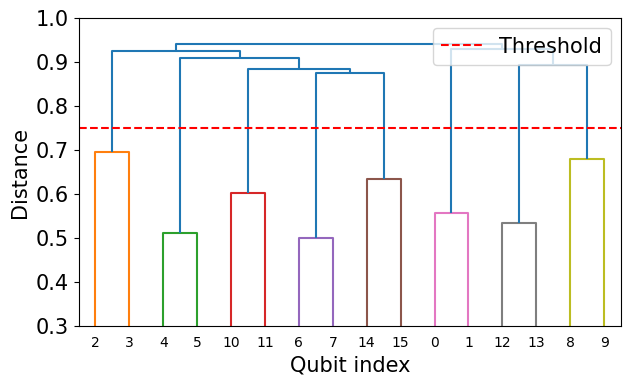

In [71]:
# Plotting dendrograms
update_cutoffs = [ 0.91, 0.75, 0.65, 0.4]
# for dict in dict_array:
#     for k_dict, cutoff in zip(dict, update_cutoffs):
#         Z = k_dict['Z']
#         #cutoff = k_dict['dendrogram_cutoff']
#         vis.plot_dendrogram(Z,save_path=f'{perm_data_path}', cutoff = cutoff, y_lim=(0.3,1) )
#         #k_dict['noise_cluster_labels'] = cl.compute_noise_cluster_labels(k_dict['Z'], k_dict['dendrogram_cutoff'])
vis.plot_dendrogram(dict_array[0][1]["Z"],save_path=f'', cutoff = 0.75, y_lim=(0.3,1) )

# Coherent noise

dict_keys(['no_QREM', 'factorized_QREM', 'two_RDM_QREM', 'classical_correlated_QREM', 'correlated_QREM', 'Z', 'noise_cluster_labels', 'two_point_corr_labels', 'rho_true_array', 'traced_down_rho_true_array', 'initial_cluster_size', 'noise_mode', 'n_QDT_shots', 'n_QST_shots_total', 'n_cores', 'n_qubits', 'n_averages', 'state_size_array', 'result_name_list', 'comparison_modes', 'dendrogram_cutoff', 'cluster_QDOT'])


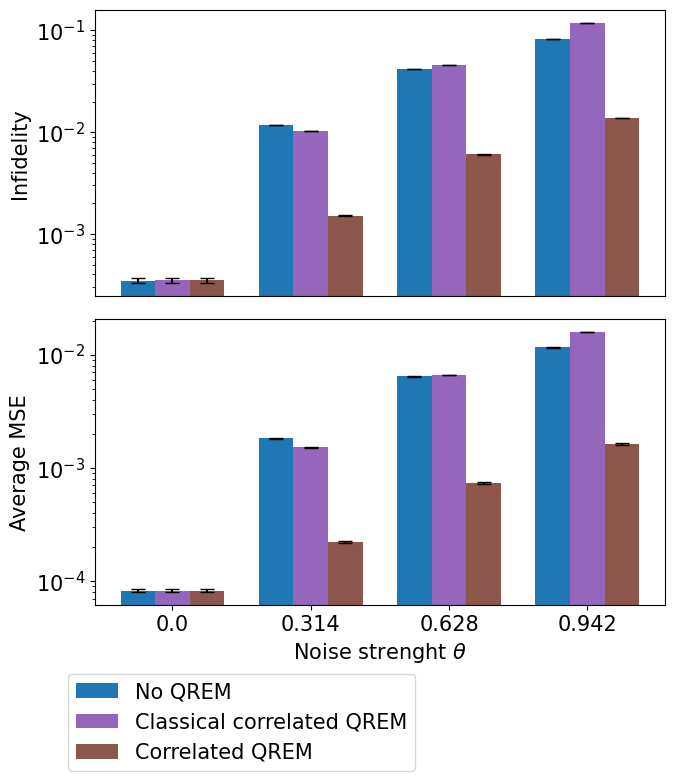

In [ ]:
#perm_data_path = "Correlated_QREM_results/coherent_example/coherent_paper_plot_100k_QST_complete_cluster_0_10_20_30"
perm_data_path = "Correlated_QREM_results/coherent_example/coherent_paper_plot_100k_QST_average_cluster_0_10_20_30"


np.set_printoptions(precision=3)
file_list = glob.glob(f'{perm_data_path}/**/*.pkl', recursive=True)
dict_array = []
print
for file in file_list:
    with open(file, 'rb') as f:
        dict_array.append(pickle.load(f))
print(dict_array[0][0].keys())
# The final numbers in the file name reflects the rotation angles used in the simulation
rot_angle_array = np.array([0,10,20,30])*np.pi/100



traced_down_rho_true_array = dict_array[0][0]['traced_down_rho_true_array']
n_averages = dict_array[0][0]['n_averages']
two_point_corr_labels   = dict_array[0][0]['two_point_corr_labels']

# Generate average Pauli expectation values
op_string_array = sf.generate_two_qubit_Pauli_string(use_identity = False)
true_exp_value = ot.compute_k_mean_expectation_values([[traced_down_rho_true_array]],op_string_array)[0,0]

# We need to treat each k-mean on it's own.
state_matrix = []
inf_matrix = []
inf = []
MSE = []

for std_it in range(len(dict_array)):
    angle_state_matrix = []
    for angle_it in range(len(dict_array[std_it])):
        state_array, label_array = ot.load_state_array_from_result_dict(dict_array[std_it][angle_it])
        #perfect_clustering_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict_array[k_it])
        angle_state_matrix.append(state_array)
        #perfect_clustering_state_matrix.append(perfect_clustering_state_array)

    state_matrix.append(angle_state_matrix)
    inf_angle_mean = ot.k_mean_infidelity_computation(angle_state_matrix, traced_down_rho_true_array).T # T is to swap order of modes and k_mean
    inf.append(inf_angle_mean)
    exp_value = ot.compute_k_mean_expectation_values(angle_state_matrix,op_string_array)
    MSE_angle_mean = ot.compute_k_mean_mean_MSE(exp_value, true_exp_value ).T # Transpose to make method be outer layer
    MSE.append(MSE_angle_mean)


inf_mean = np.mean(inf, axis = 0)
MSE_mean = np.mean(MSE, axis = 0)



x = np.arange(len(rot_angle_array))  # the k-mean label locations
color_array = ['C0', 'C4', 'C5']
width = 0.25  # the width of the bars
multiplier = 0
# The shape of the array is 
fig, ax = plt.subplots(2,1)

for i in range(len(label_array)): 
    offset = width * multiplier
    rects = ax[0].bar(x + offset, inf_mean[i], width,label=label_array[i], color = color_array[i]) # Transpose to make method be outer layer
    ax[0].errorbar(x + offset, inf_mean[i], yerr=np.std(inf, axis=0)[i], fmt='none', ecolor='k', capsize=5)
       
    #ax[0].plot(x + offset, inf_average_perfect_clustering[i], "kx", label="Perfect clustering" if multiplier == 0 else "")
    multiplier += 1

ax[0].set_yscale('log')
#ax[0,0].set_title(rf"Average over {n_averages} states.")
ax[0].set_xticks(x + width, rot_angle_array)
ax[0].set_ylabel('Infidelity')



# Generate average Pauli expectation values

op_string_array = sf.generate_two_qubit_Pauli_string(use_identity = False)


multiplier = 0
for i in range(len(label_array)):
    offset = width * multiplier
    rects = ax[1].bar(x + offset, MSE_mean[i], width, color = color_array[i])
    ax[1].errorbar(x + offset, MSE_mean[i], yerr=np.std(MSE, axis=0)[i], fmt='none', ecolor='k', capsize=5) 
    #ax[1].plot(x + offset, perfect_clustering_MSE[i], "kx",)
    multiplier += 1
    

ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')

ax[-1].set_xticks(x + 1*width, np.round(rot_angle_array, 3))
ax[-1].set_xlabel(r'Noise strenght $\theta$')


fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(0.1,-.05))
fig.savefig(f'images/Results/coherence_example.png', dpi = 300, bbox_inches='tight')

In [ ]:

# Plotting dendrograms
update_cutoffs =[ 0.9, 0.8, 0.6, 0.7]  
for dict in dict_array:
    for rot_dict, cutoff in zip(dict, update_cutoffs):
        Z = rot_dict['Z']
        #print(rot_dict["noise_cluster_labels"])
        #print(rot_dict['two_point_corr_labels'])
        #print(rot_dict[''])
        cutoff = rot_dict['dendrogram_cutoff']
        #print(cutoff)
        vis.plot_dendrogram(Z,save_path=f'{perm_data_path}', cutoff = cutoff)
        #k_dict['noise_cluster_labels'] = cl.compute_noise_cluster_labels(k_dict['Z'], k_dict['dendrogram_cutoff'])

# 100 qubit example

[[-3.424e-01 -2.287e-02 -7.458e-02  5.519e-02  2.073e-01 -4.258e-02
  -2.257e-01 -2.534e-02  7.474e-02 -2.028e-01  4.731e-03 -6.183e-02
  -3.152e-02  3.031e-02  4.557e-03 -1.883e-02  2.247e-02  2.240e-02
  -9.055e-02 -2.615e-02 -4.374e-03 -3.586e-02 -5.078e-03 -4.375e-02
  -6.585e-05 -5.945e-03  1.585e-02  2.314e-02  3.220e-03 -4.647e-02
  -4.116e-02 -1.112e-01  1.362e-02 -5.234e-03 -3.891e-02  1.557e-01
   6.856e-02  8.242e-02  1.251e-01 -9.903e-02  4.694e-03 -4.045e-03
   1.116e-01 -3.542e-03 -9.963e-02  3.739e-01  6.551e-02  1.073e-01
   1.285e-01  1.307e-01 -6.289e-03  9.457e-03  2.313e-02  5.260e-03
  -3.244e-02  7.244e-03 -9.926e-03  1.468e-01 -3.036e-03  6.808e-03
  -2.786e-02 -2.001e-02 -3.886e-02 -3.504e-02 -1.306e-01  3.115e-01
  -4.253e-02 -1.076e-02  3.067e-02 -5.740e-02 -1.953e-02  2.841e-02
  -6.580e-02  5.316e-02  2.328e-04 -2.122e-01 -1.794e-02  3.937e-02
   1.012e-02 -4.472e-02  1.870e-02  1.160e-01  2.433e-02 -2.814e-02
  -1.900e-01 -1.344e-02  5.359e-02  2.966e-05 -4

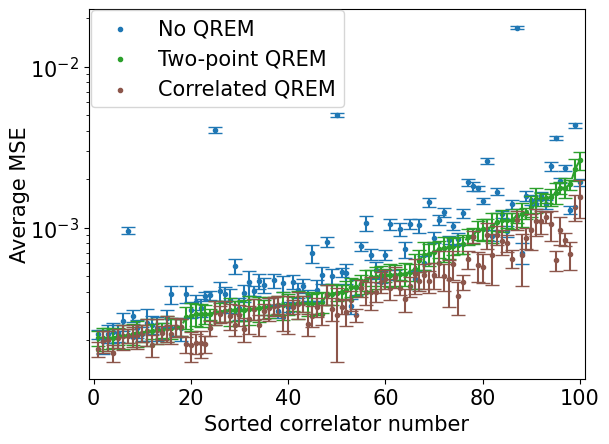

In [ ]:
perm_data_path = 'Correlated_QREM_results/100_qubit_example/50k_QST_10_averages' 
file_list = glob.glob(f'{perm_data_path}/**/*.pkl', recursive=True)
dict_array = []
for file in file_list:
    with open(file, 'rb') as f:
        dict_array.append(pickle.load(f))
    

#perfect_clustering_dict = dict_array[1]
n_averages = dict_array[0]['n_averages']
two_point_corr_labels   = dict_array[0]['two_point_corr_labels']
traced_down_rho_true_array = dict_array[0]['traced_down_rho_true_array']


#standard_state_array, label_array = ot.load_state_array_from_result_dict(standard_dict)
#perfect_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict)


op_string_array = sf.generate_two_qubit_Pauli_string(use_identity = False)

true_exp_value = ot.compute_state_array_exp_values([traced_down_rho_true_array],op_string_array)[0]
print(true_exp_value[:,:,-1])
#inf_array = []
state_array = []
MSE_array = []
for dict in dict_array:
    state, label_array = ot.load_state_array_from_result_dict(dict)
    print(np.array(state).shape)
    print(label_array)
    
    # The states has shapes [n_modes, n_averages, len(two_point_corr_labels), 2**n_qubits, 2**n_qubits]
    #inf_array.append(ot.compute_mode_mean_infidelitites(state, traced_down_rho_true_array))#[filter_array]
    state_array.append(state)
    exp_value = ot.compute_state_array_exp_values(state,op_string_array)
    MSE_array.append(ot.compute_op_and_n_averages_mean_MSE(exp_value, true_exp_value))
    # Resulting arrays have shapes [std_averages,n_modes,n_correlators]
print(np.array(MSE_array).shape)
mean_MSE_array = np.mean(MSE_array, axis=0)
print(mean_MSE_array.shape)
sorting_arg = np.argsort(mean_MSE_array.T[:,1])
sorted_MSE = mean_MSE_array.T[sorting_arg]
# average_values = np.mean(sorted_MSE,axis=0)

colors = ['C0', 'C2', 'C5']
#colors = ['C0', 'C1','C2','C4' ,'C5']
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(len(sorted_MSE[:,1]))+1,sorted_MSE[:,1],linestyle='dashed',color='C2' )
for i in range(len(sorted_MSE[0])):
    ax.scatter(np.arange(len(sorted_MSE[:,i]))+1, sorted_MSE[:,i],label = label_array[i], color = colors[i], marker='.')
    ax.errorbar(np.arange(len(sorted_MSE[:,i]))+1, sorted_MSE[:,i], yerr=np.std(MSE_array, axis=0).T[sorting_arg][:,i], fmt='none', ecolor=colors[i], capsize=5)


ax.set_yscale('log')
ax.set_ylabel(f'Average MSE', labelpad=0)
ax.set_xlabel('Sorted correlator number')
ax.set_xlim(-1,101)
fig.legend(bbox_to_anchor=(0.54,0.9))

fig.savefig(f'images/Results/100_qubit_example.png',  dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.1)




[99 98 97]
[96]
[95 94 93 92]
[91 90]
[89]
[88]
[87 86]
[85 84]
[83]
[82]
[81 80]
[79 78]
[77 76]
[75]
[74 73]
[72]
[71 70]
[69 68]
[67 66]
[65 64]
[63]
[62 61 60]
[59]
[58]
[57]
[56]
[55 54 53]
[52]
[51 50 49 48]
[47 46 45 44]
[43 42 41 40]
[39 38 37 36]
[35 34]
[33]
[32]
[31 30]
[29 28]
[27 26 25 24]
[23]
[22 21 20]
[19 18 17]
[16]
[15 14]
[13 12]
[11 10]
[9 8]
[7 6]
[5 4]
[3 2]
[1]
[0]


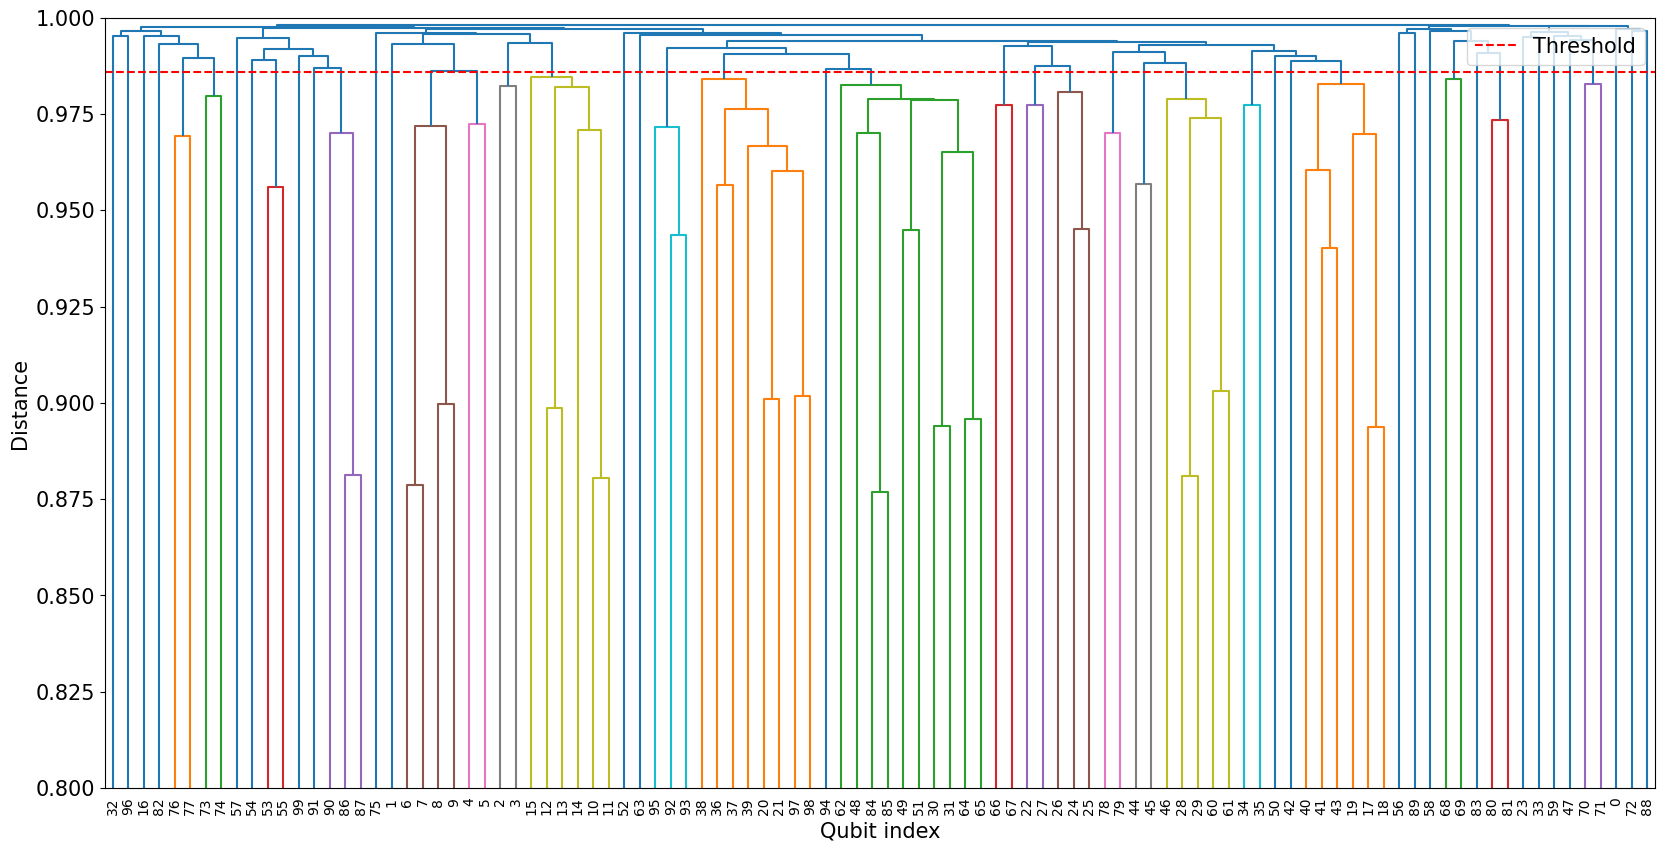

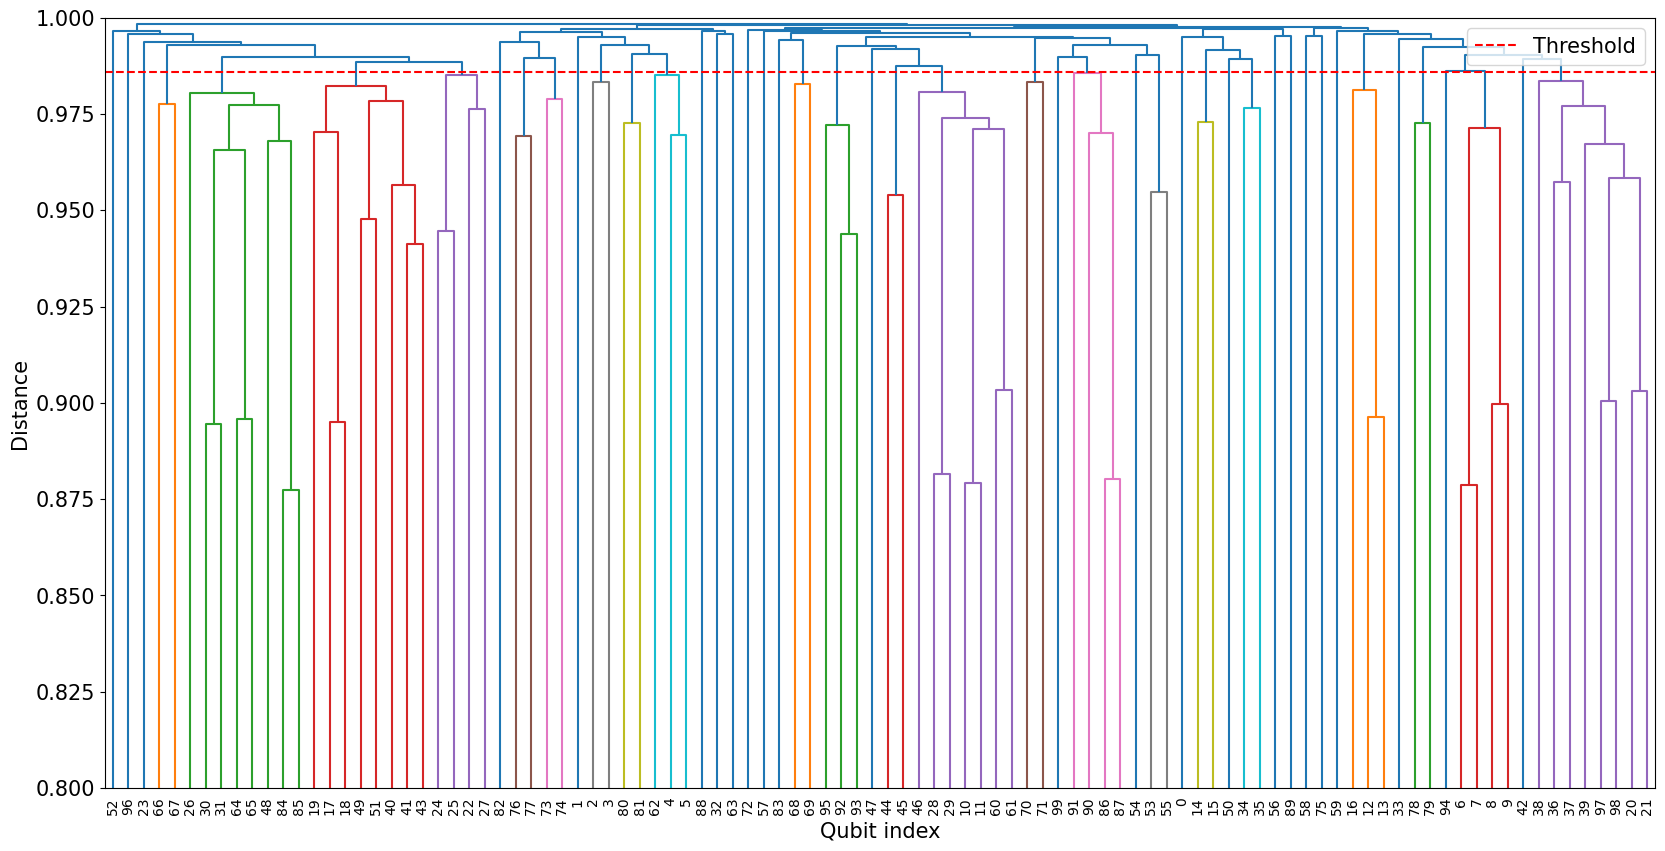

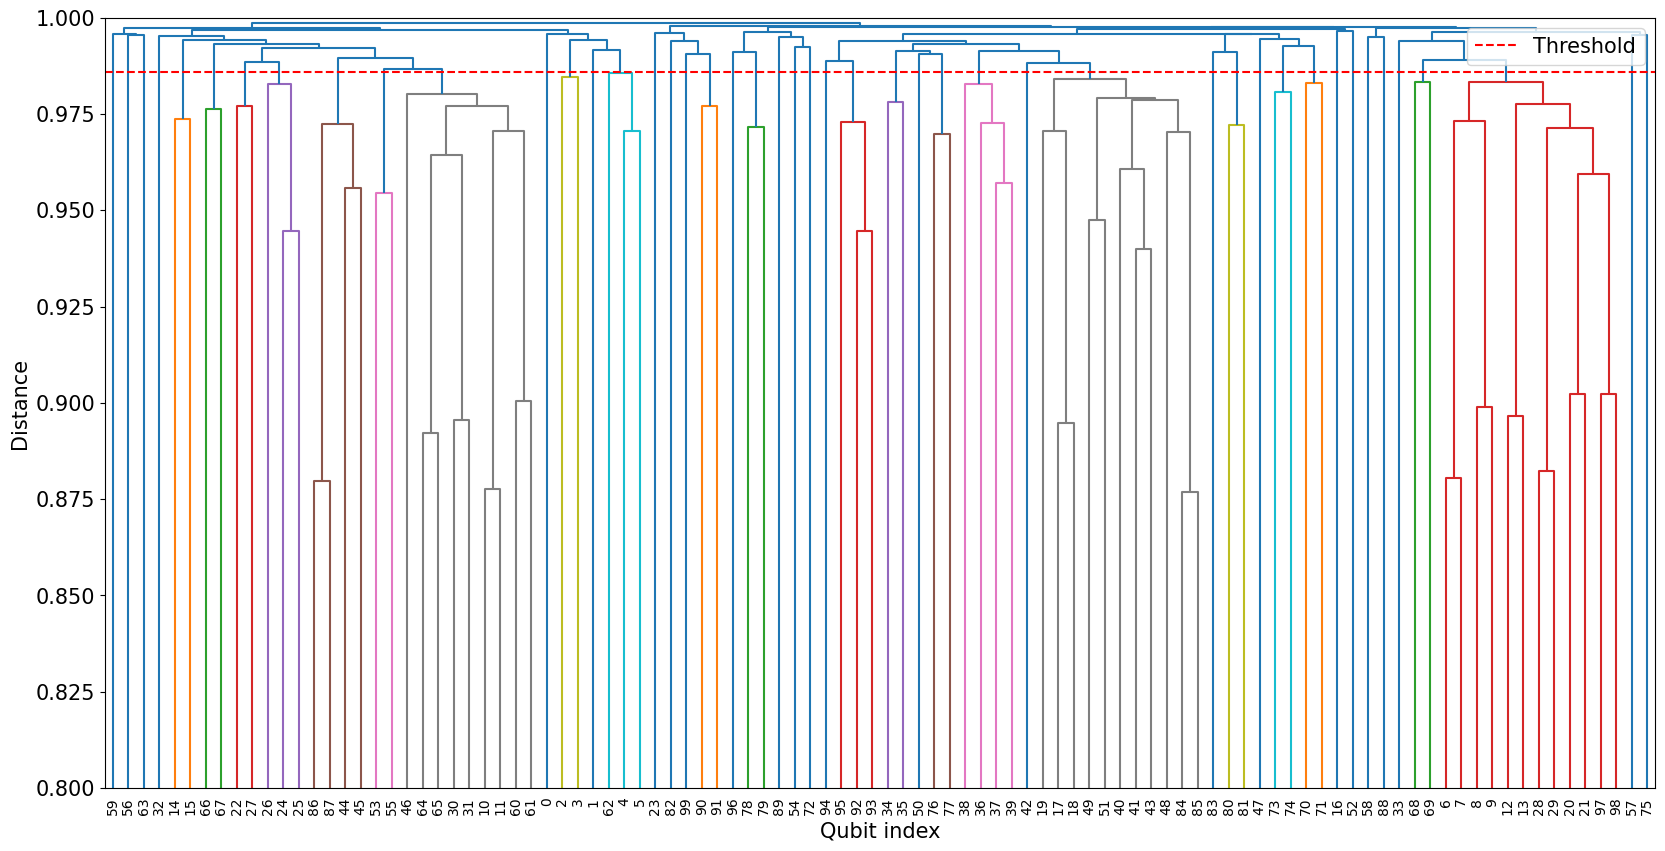

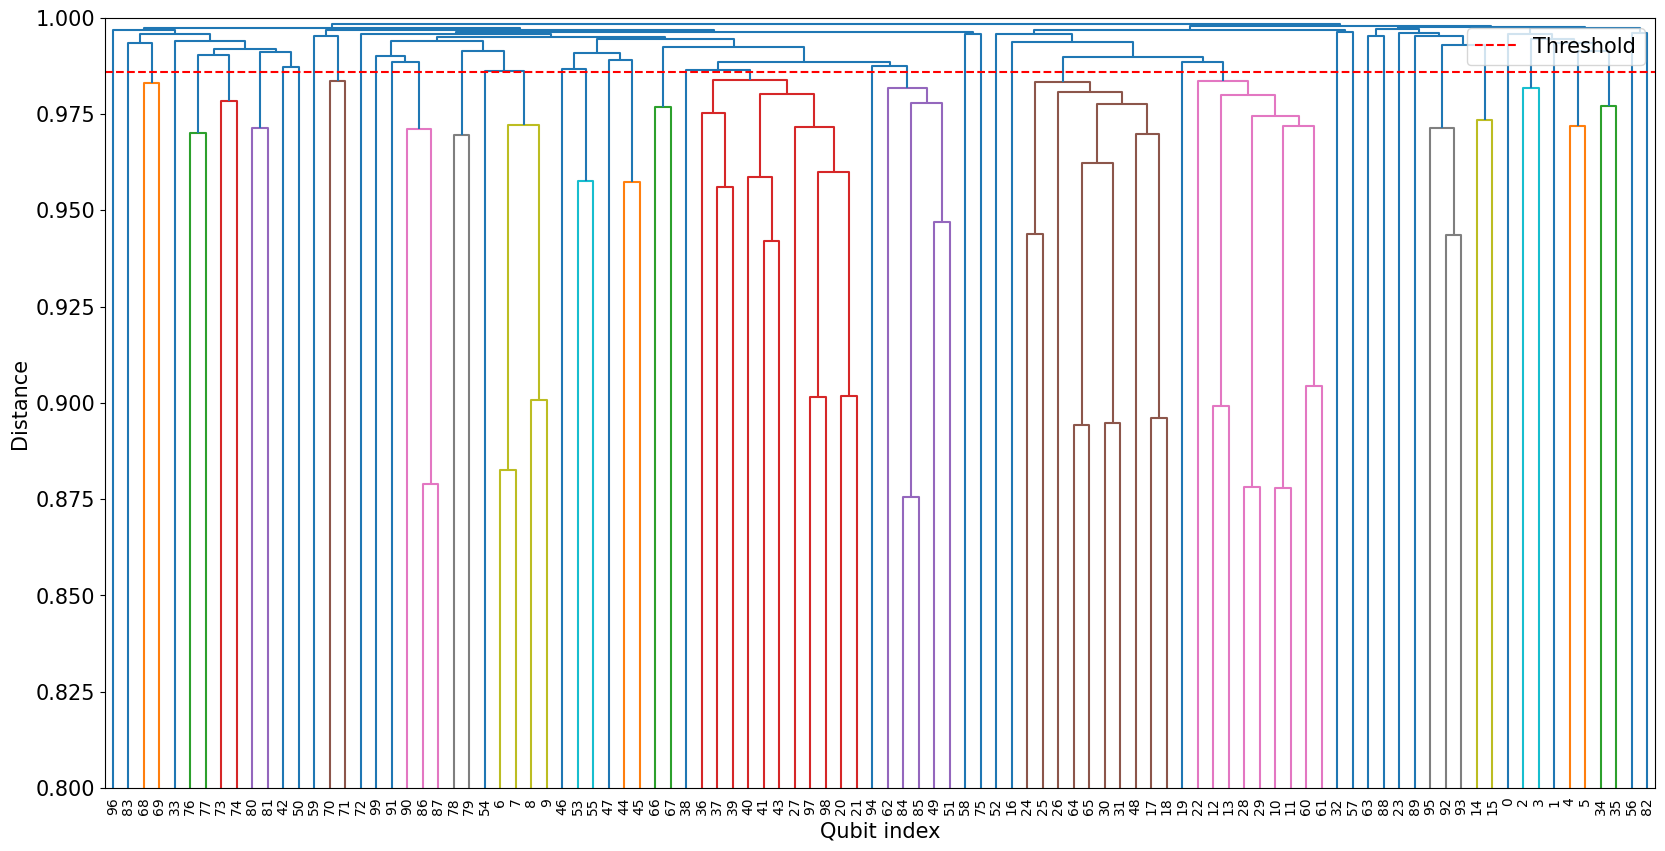

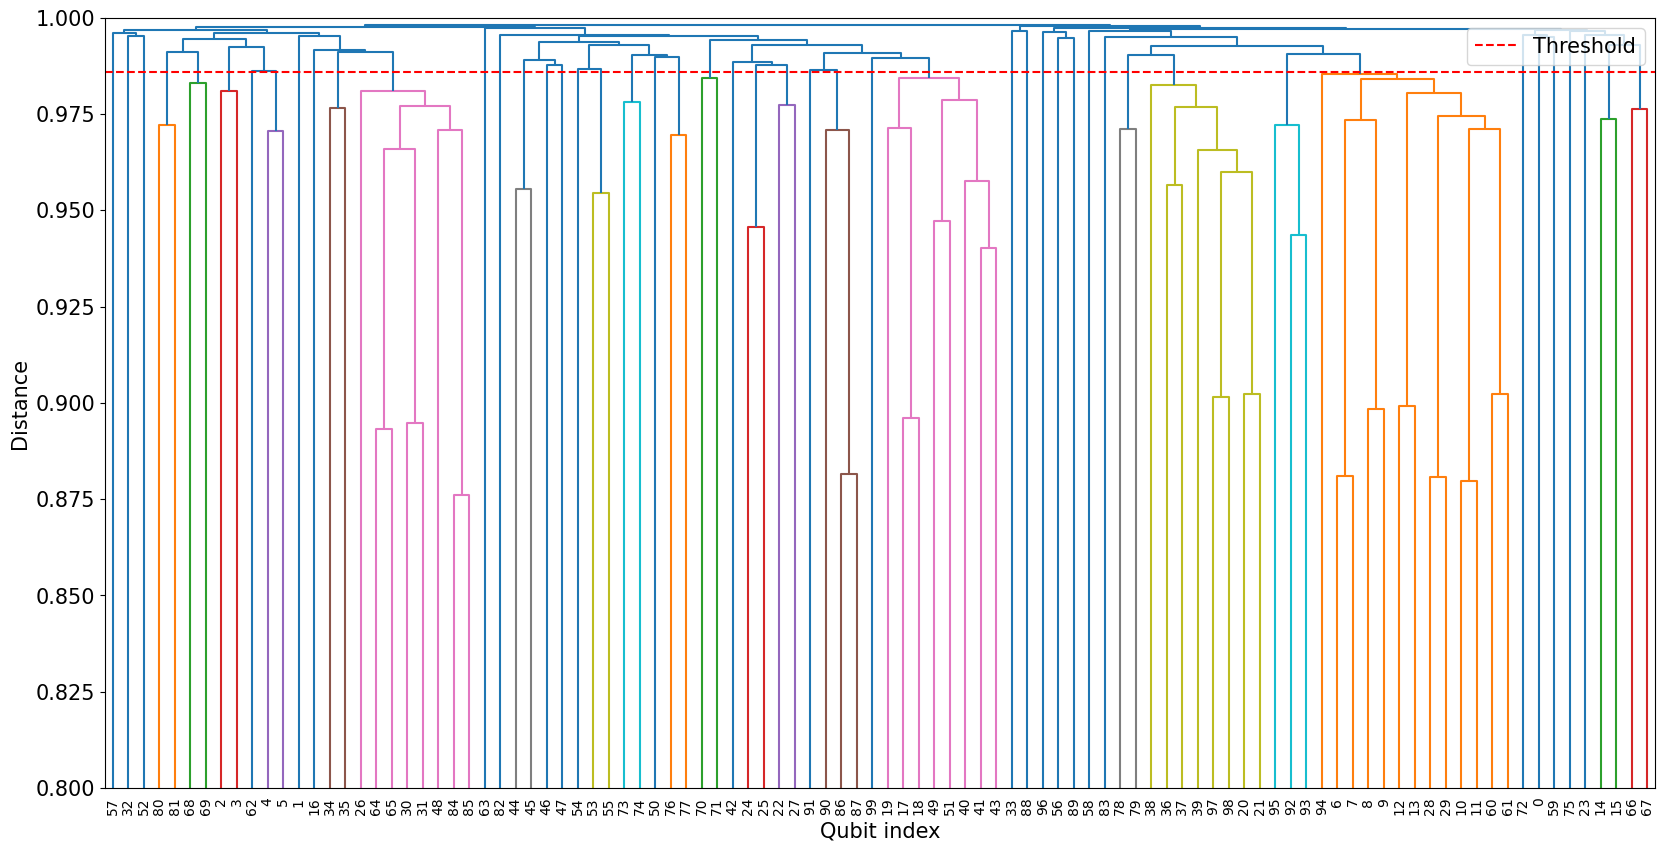

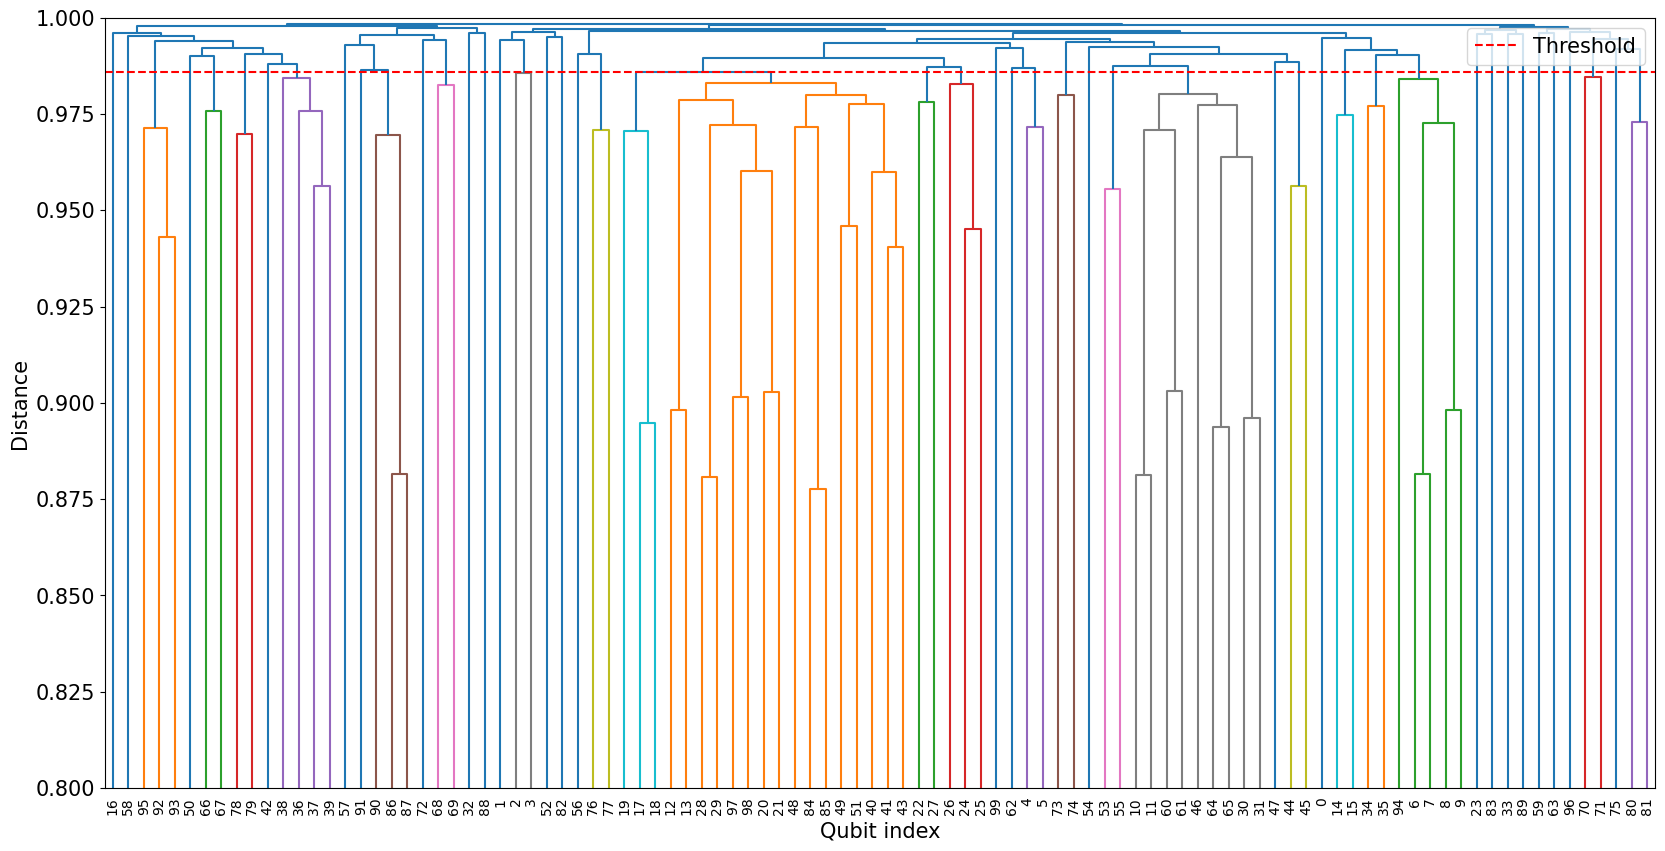

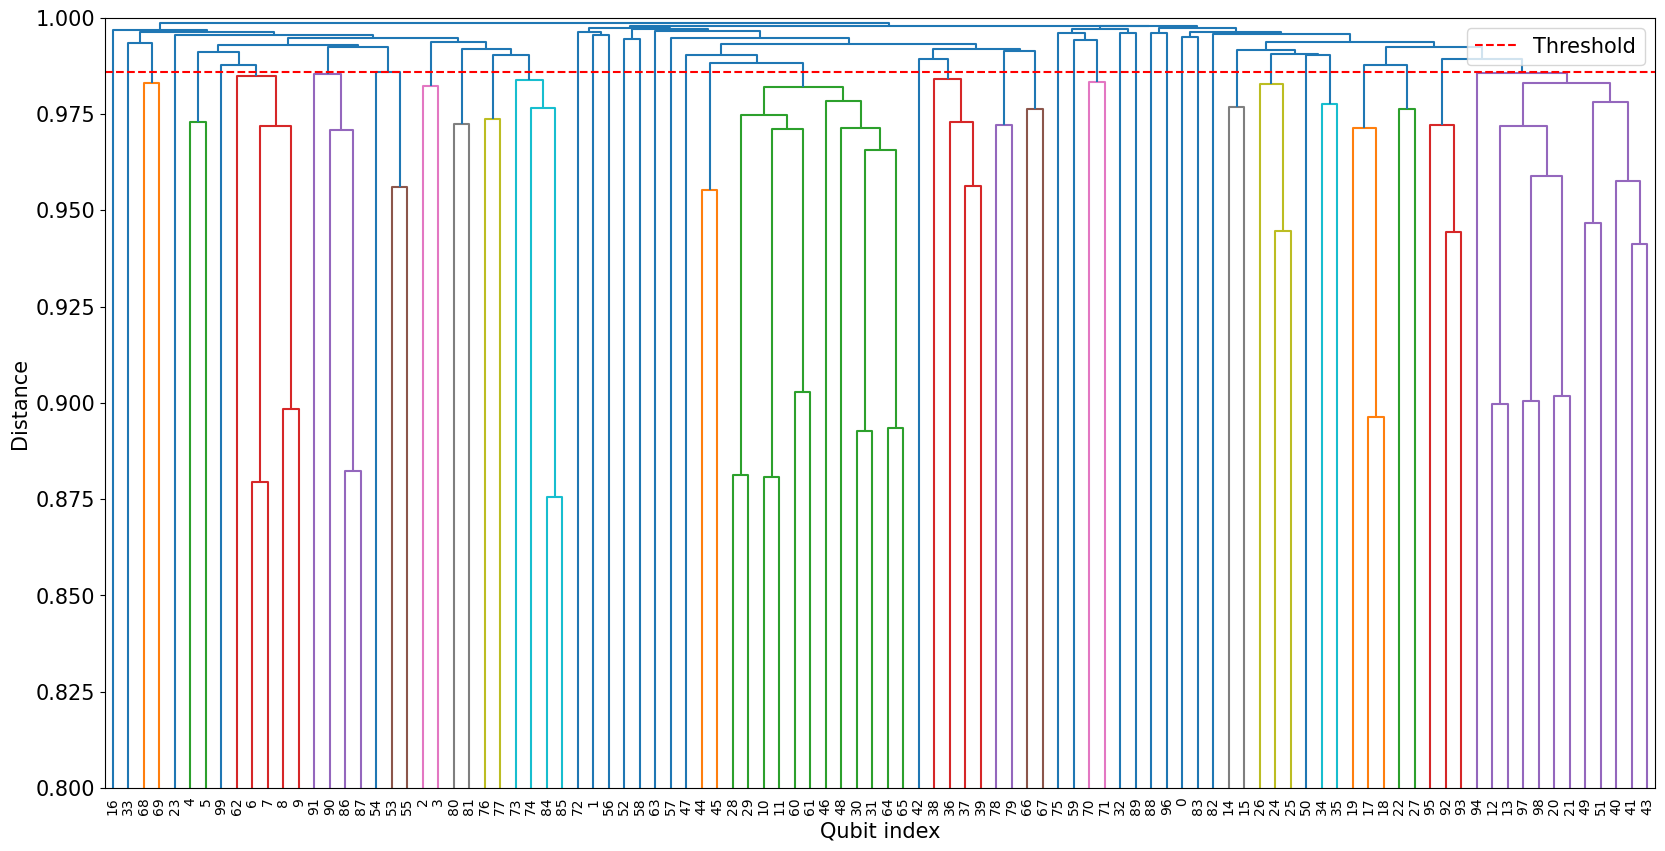

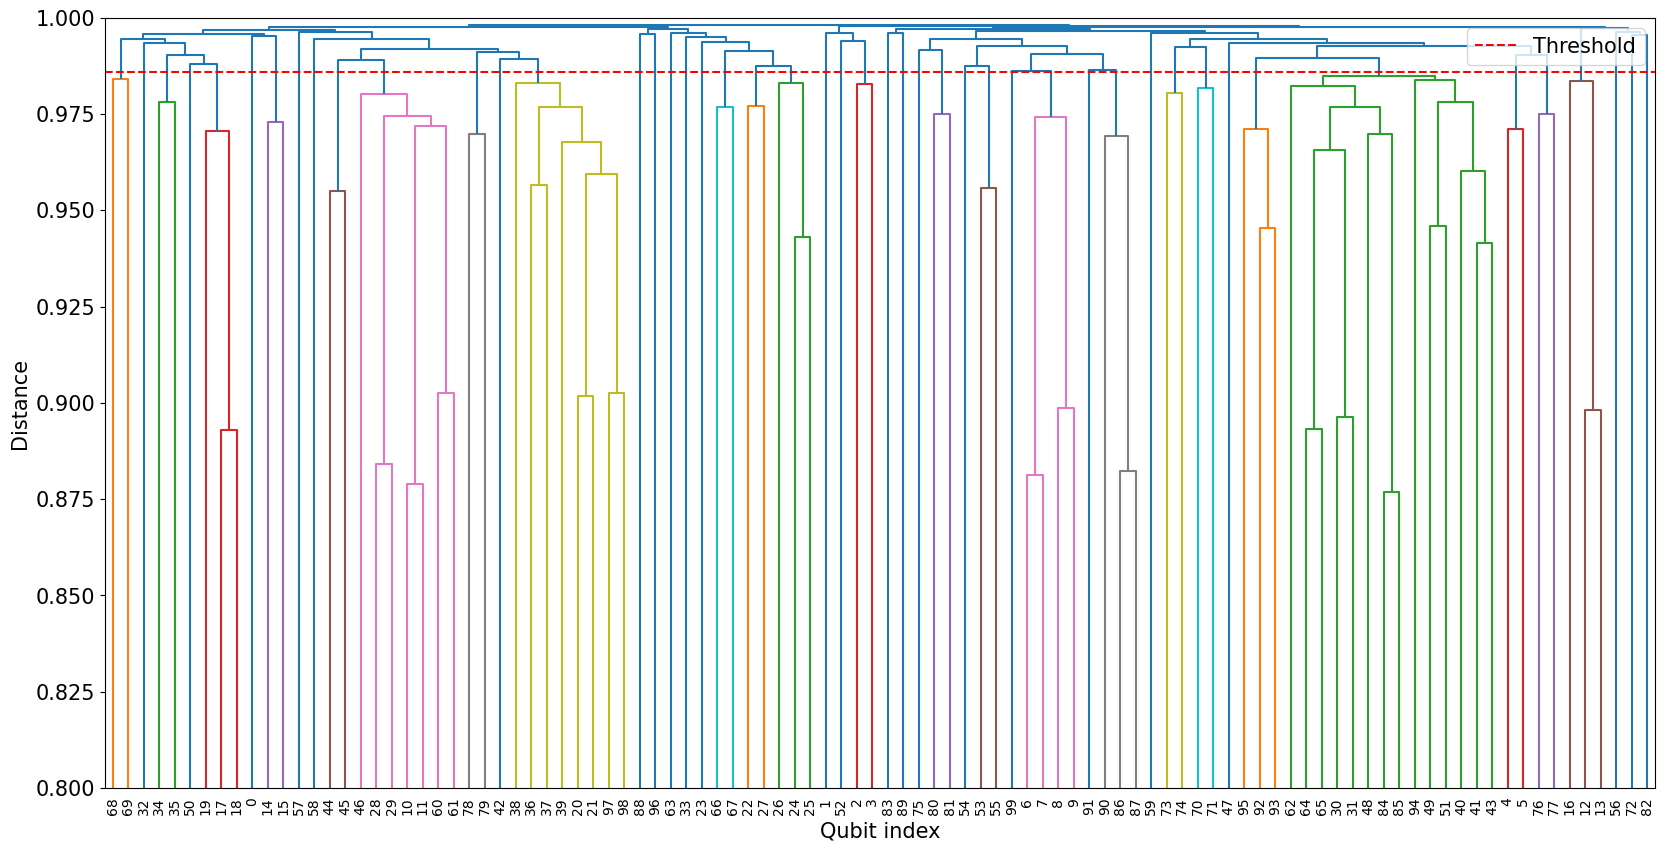

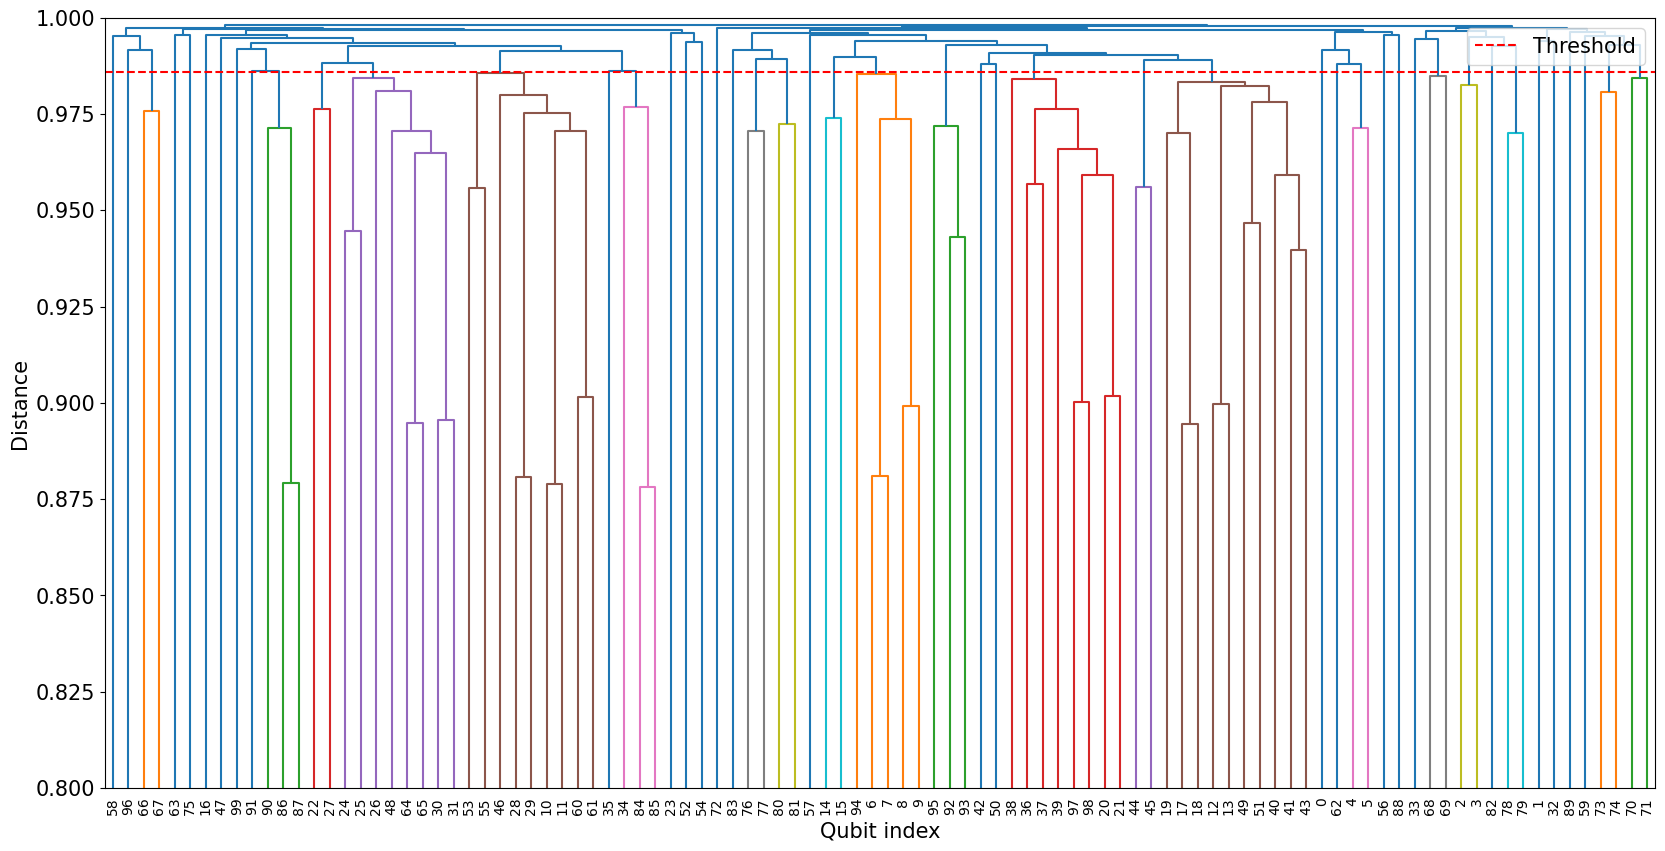

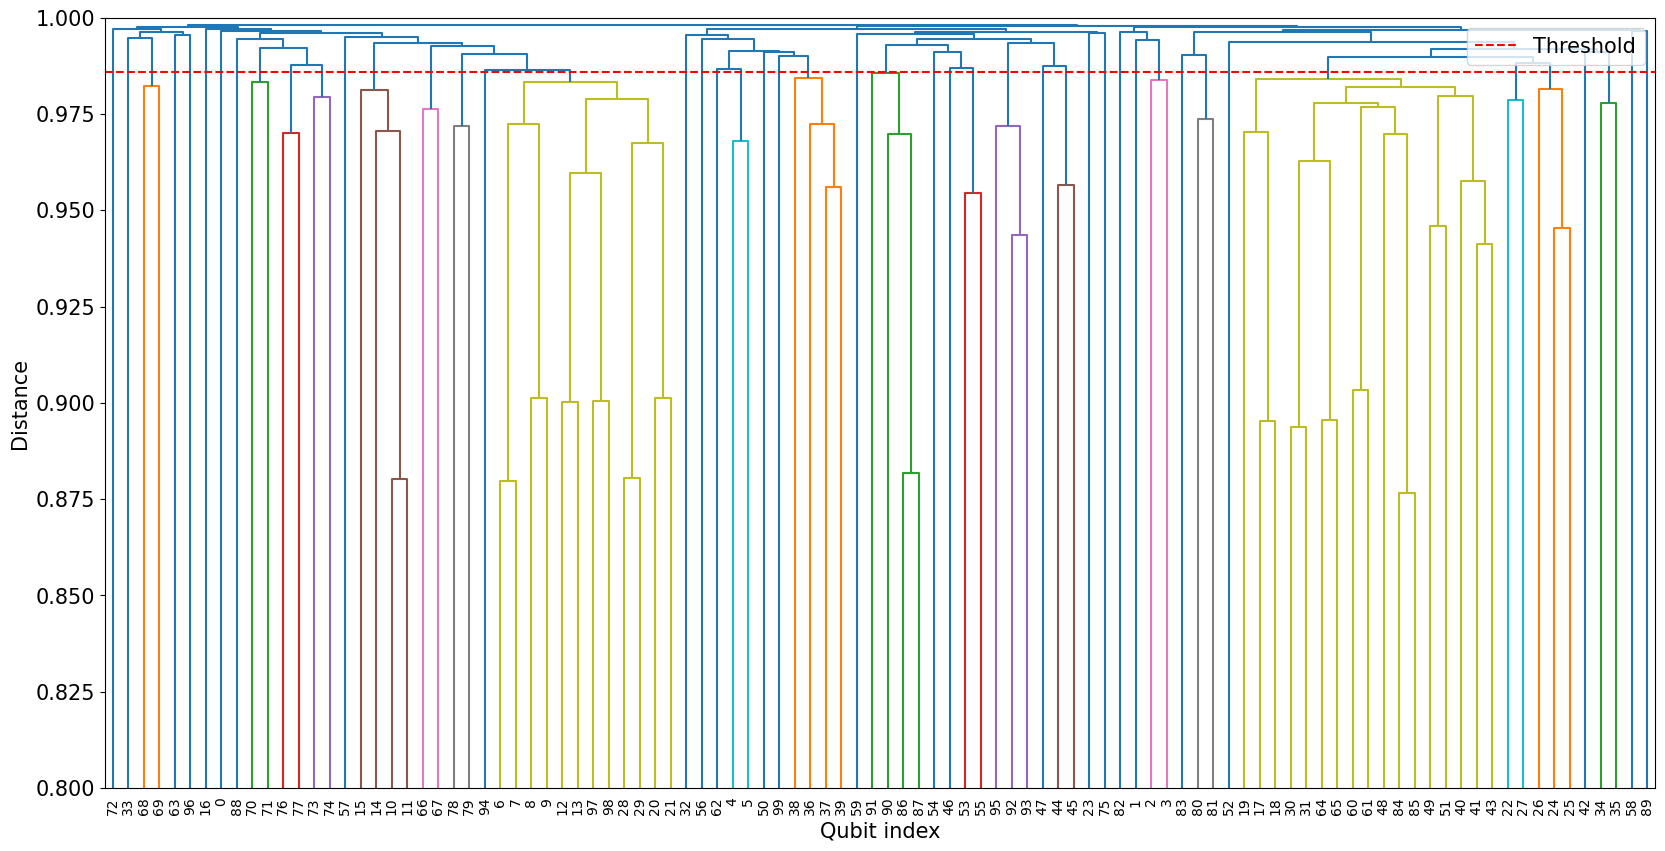

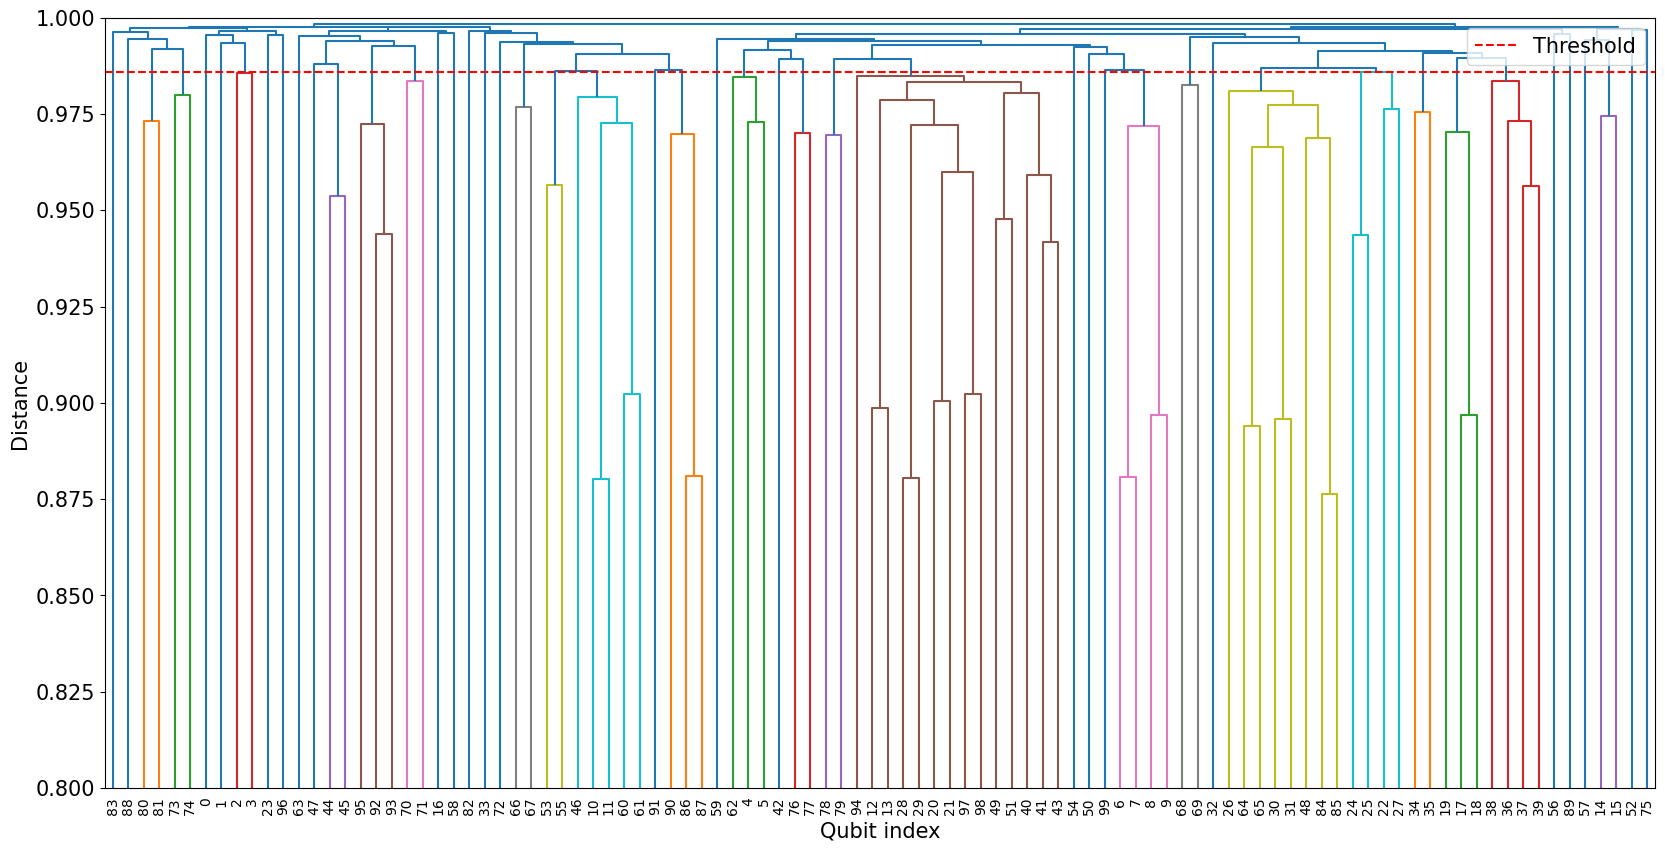

In [12]:
# Plotting dendrograms
update_cutoffs = [ 0.91, 0.75, 0.65, 0.4]
inital_cluster = dict_array[0]['initial_cluster_size']
cluster  = cl.get_true_cluster_labels(inital_cluster)
for entry in cluster:
    print(entry)
for dict in dict_array:
    
    Z = dict['Z']
    #print(rot_dict["noise_cluster_labels"])
    #print(rot_dict['two_point_corr_labels'])
    #print(rot_dict[''])
    cutoff = dict['dendrogram_cutoff']
    vis.plot_dendrogram(Z,save_path=f'{perm_data_path}', cutoff = cutoff, plot_shape=(20,10),y_lim =(0.8,1) )
    #k_dict['noise_cluster_labels'] = cl.compute_noise_cluster_labels(k_dict['Z'], k_dict['dendrogram_cutoff'])